# Rangelands dynamics with Sentinel-1

This notebook gives an example of using Sentinel-1 analysis ready data (ARD) radar backscatter (Gamma nought) and dual-polarimetric decomposition (Alpha, Entropy and Anisotropy) for exploring annual rangeland dynamics.

Sentinel-1 (in this case it is the dual-pol Radar Vegetation Index (RVI) and Entropy bands) and Sentinel-2 NDVI are compared for multitemporal trends due to their relationships with vegetation biomass. A grasslands mask (read in as a shape file) is then applied to extract only the areas of interest, before the monthly means are generated for the RVI and Entropy bands. These monthly means as well as the annual range in RVI and Entropy are then output as GeoTIFF files.

The following steps are used:
1.  Load Sentinel-1 radar backscatter data through the datacube API
2.  Apply speckle filtering
3.  Calculate the dual-pol Radar Vegetation Index (RVI)
4.  Load Sentinel-1 dual-pol decomposition data
5.  Load Sentinel-2 data and calculate NDVI
6.  Interactively compare RVI, Entropy and NDVI time series
7.  Show annual statistics
8.  Generate monthly means
9.  Save results to GeoTIFF files

This notebook was written using the Virtual Desktop Infrastructure (VDI) on the National Computational Infrastructure (NCI), allowing access to the current Sentinel-1 and Digitial Earth Australia (DEA) ARD datasets. For this notebook to work you must first load the relevant modules:
-  module use /g/data/v10/public/modules/modulefiles
-  module load dea

# 1. Load Sentinel-1 radar backscatter data through the datacube API

Area of interest is in the Fitzroy Catchment of Western Australia

In [1]:
# Import relevant modules for this Jupyter Notebook and start datacube

import datacube
import numpy as np
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
from IPython.display import display
from IPython.display import HTML
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore', module='datacube')

dc = datacube.Datacube(config='radar.conf')

In [21]:
# run this cell to hide all code within notebook

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Select area of interest for year of interest 
>  Currently only use 2017 or 2018 for full years <br>
>  Note that the area of interest must be small to avoid memory issues

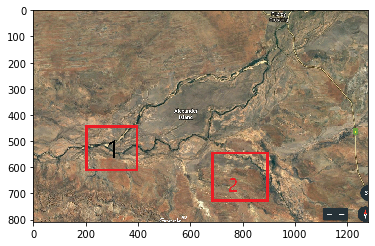

interactive(children=(Dropdown(description='mysite', options=('Site1', 'Site2'), value='Site1'), Output()), _d…

In [3]:
import ipywidgets as widgets
from ipywidgets import interact
#from matplotlib import pyplot as plt
import matplotlib.image as mplImage
image = mplImage.imread('/g/data/qd04/Cate/TempProcessing/LocImage.png')
plt.imshow(image)

@interact(mysite=['Site1','Site2'])

def plot(mysite='Site1'):
    global latn, lats, lonw, lone, myloc
    if mysite == 'Site1': lats, latn, lonw, lone, myloc = -18.6, -18.4, 125.0, 125.2, 'Site1'
    if mysite == 'Site2': lats, latn, lonw, lone, myloc = -18.8, -18.6, 125.5, 125.7, 'Site2'

In [4]:
# Select Year

@interact(myyear=['2017','2018'])

def plot(myyear='2017'):
    global yearSel
    if myyear == '2017': yearSel = '2017'
    if myyear == '2018': yearSel = '2018'
        
# Define area of interest and year within a query

Year = yearSel

query = {

'y': (lats, latn),
'x': (lonw, lone),
    
'time': (Year + '-01-01', Year + '-12-31'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}

interactive(children=(Dropdown(description='myyear', options=('2017', '2018'), value='2017'), Output()), _dom_…

# Read radar backscatter, clean and smooth data

In [5]:
bs=dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', **query)

# Identify images that have minimum nulls
# Uses code from https://github.com/fangfy/dea-projects/blob/master/water_interoperability/sentinel1_load_and_classify_nci.ipynb

total_px=len(bs.x)*len(bs.y)
valid=bs.where(bs.vv!=0).where(bs.vh!=0).count(dim=('x','y'))

good=(valid.vh/total_px)>0.5

bs_good = bs.sel(time=good)
# replace 0 with nan
bs_clean = bs_good.where(bs_good!=0)

# Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

# save the nodata mask
nodata_mask = bs_clean.isnull().to_array().any(axis=0)
# Convert backscatter nans to 0 for lee filter
bs_good_zerofilled = bs_good.where(~bs_good.isnull(), 0)

# Apply speckle filter
smoothed_vv=bs_good_zerofilled.vv.groupby('time').apply(lee_filter, size=7)
smoothed_vh=bs_good_zerofilled.vh.groupby('time').apply(lee_filter, size=7)

# Create smoothed dataset with Nans and assign attributes
smoothed=smoothed_vv.to_dataset(name='vv')
smoothed['vh']=smoothed_vh
smoothed=smoothed.where(~nodata_mask)

# Remove unused data
bs_attrs = bs.attrs
smoothed = smoothed.assign_attrs(bs_attrs)

del bs, bs_good, bs_clean
print('Backscatter data for ', myloc,': ',smoothed)

Backscatter data for  Site1 :  <xarray.Dataset>
Dimensions:  (time: 29, x: 891, y: 932)
Coordinates:
  * y        (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x        (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
  * time     (time) datetime64[ns] 2017-01-06T21:06:37.067738 ... 2017-12-20T21:06:46.267397
Data variables:
    vv       (time, y, x) float32 0.058082025 0.06558088 ... 0.08221259
    vh       (time, y, x) float32 0.019151364 0.023157777 ... 0.021565245
Attributes:
    crs:      EPSG: 3577


## View smoothed images (VV or VH)

In [6]:
# View smoothed data (Note - you might need to edit 'figsize' to improve appearance)

ntimes=len(smoothed.time.values)

@interact(mypol=['VV','VH'])

def plot(mypol='VV'):
    if mypol == 'VV': smoothed.vv.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=0, vmax=0.2, figsize=(14,12));
    if mypol == 'VH': smoothed.vh.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=0, vmax=0.08, figsize=(14,12));


interactive(children=(Dropdown(description='mypol', options=('VV', 'VH'), value='VV'), Output()), _dom_classes…

## Calculate and view modified dual-pol Radar Vegetation Index images

<IPython.core.display.Javascript object>


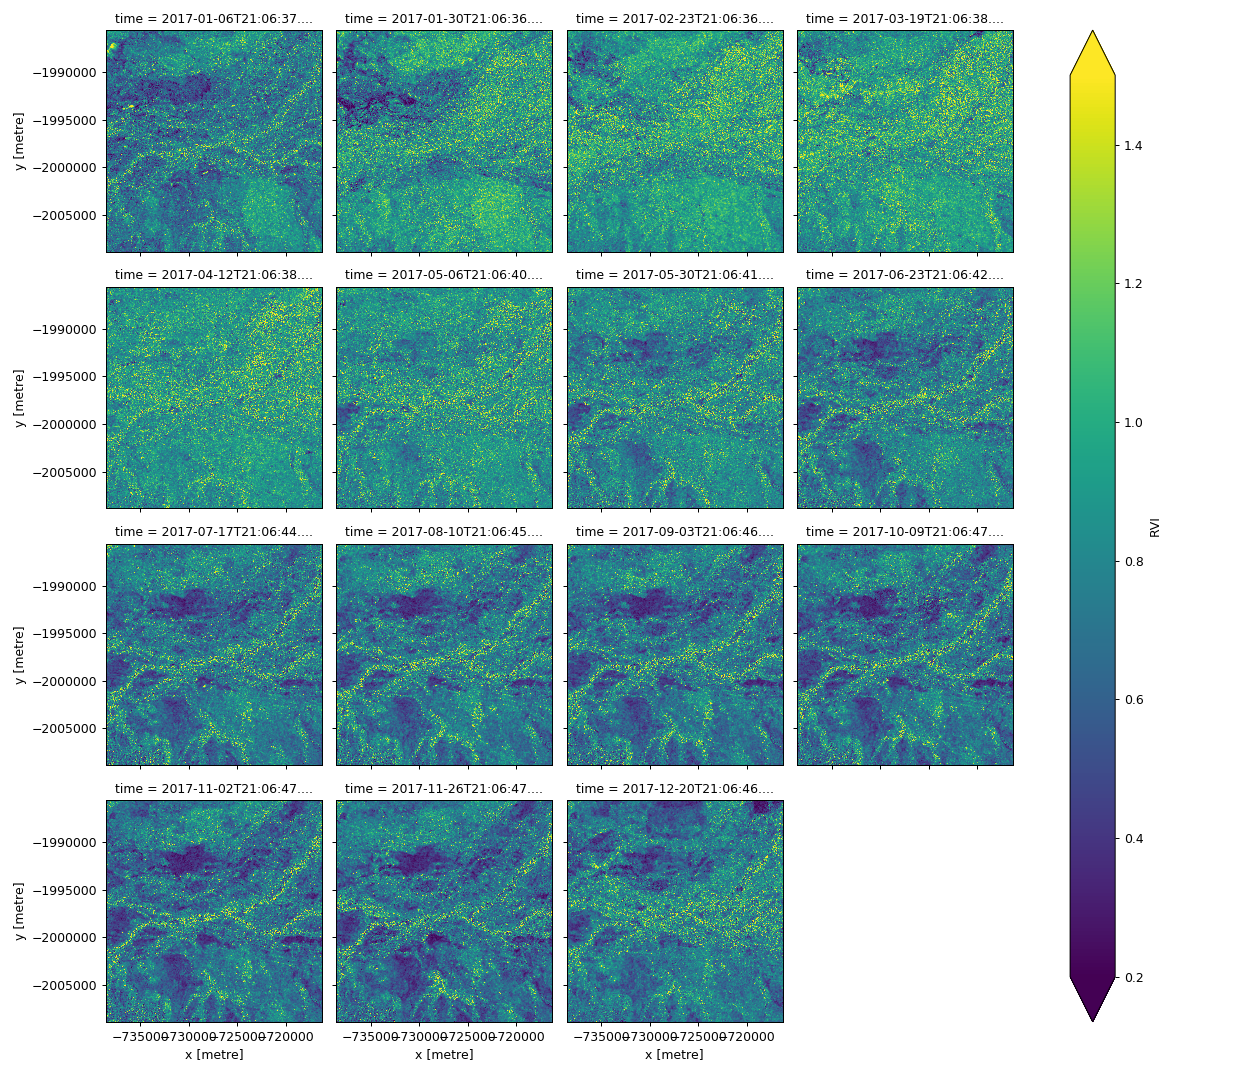

In [12]:
# View RVI data

smoothed['RVI'] = 4*smoothed.vh/(smoothed.vv + smoothed.vh)

ntimes=len(smoothed.time.values)
smoothed.RVI.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=0.2, vmax=1.5, figsize=(14,12));

# Read in dual-pol decomposition data
## This results in Alpha, Anisotropy and Entropy bands

In [7]:
dp=dc.load(product='s1_haalpha_scene', group_by='solar_day', **query)

dp = dp.where(dp.entropy!=0)
print('Dual polarimetric decomposition data for ', myloc,': ',dp)

Dual polarimetric decomposition data for  Site1 :  <xarray.Dataset>
Dimensions:     (time: 59, x: 891, y: 932)
Coordinates:
  * time        (time) datetime64[ns] 2017-01-06T21:06:37.194455 ... 2017-12-25T21:14:51.529181
  * y           (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x           (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
Data variables:
    entropy     (time, y, x) float32 0.82229125 0.7376541 ... 0.85633445
    anisotropy  (time, y, x) float32 0.4847056 0.583905 ... 0.43876868
    alpha       (time, y, x) float32 58.153442 64.67583 ... 67.36098 59.55295
Attributes:
    crs:      EPSG: 3577


## View Alpha or Entropy images

In [8]:
ntimes=len(dp.time.values)

# View entropy (values range from 0-1.0) data 
# (can also change to look at 'anisotropy' (values ~0-1.0))

@interact(mypol=['Alpha','Entropy'])

def plot(mypol='Alpha'):
    if mypol == 'Alpha': dp.alpha.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=40, vmax=80.0, figsize=(14,16));
    if mypol == 'Entropy': dp.entropy.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=0, vmax=1.0, figsize=(14,16));


interactive(children=(Dropdown(description='mypol', options=('Alpha', 'Entropy'), value='Alpha'), Output()), _…

# Load Sentinel-2 to extract NDVI time series

In [9]:
dc_S2 = datacube.Datacube(app='dc-S2-extract')

# Read S2 green, nir and cloud mask bands for S2a and S2b
bands_of_interest = ['nbar_green', 'nbar_nir_2', 'fmask']
sensors = ['s2a','s2b']

s2 = {}
for sensor in sensors:
    s2[sensor] = dc_S2.load(product = sensor+'_ard_granule', group_by='solar_day', measurements = bands_of_interest, **query)
    
# Combine the S2a and S2b dates
s2_clean = xr.concat(s2.values(), dim='time')

del s2

# Remove clouds and nulls from S2 data
nbar_green = s2_clean.nbar_green
s2_good=nbar_green.to_dataset(name='green')
s2_good['nir']=s2_clean.nbar_nir_2
s2_good['fmask']=s2_clean.fmask

s2_good_temp = s2_good.where(s2_good.fmask<2) # to remove cloud/shadow/nulls based on fmask
s2_good_clean = s2_good_temp.where(s2_good_temp.fmask!=0)

s2_good_clean = s2_good_clean.assign_attrs(bs_attrs)

del s2_good

# Create NDVI band
s2_good_clean['ndvi']=(s2_good_clean.nir.astype(float) - s2_good_clean.green.astype(float))/(s2_good_clean.nir.astype(float) + s2_good_clean.green.astype(float))

# Remove any remaining erroneous values (where NDVI <-1.0 and NDVI > 1.0)
s2_good_clean = s2_good_clean.where(s2_good_clean.ndvi > -1.0).where(s2_good_clean.ndvi < 1.0)
print('Sentinel-2 data for ', myloc,': ',s2_good_clean)

Sentinel-2 data for  Site1 :  <xarray.Dataset>
Dimensions:  (time: 61, x: 891, y: 932)
Coordinates:
  * y        (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x        (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
  * time     (time) datetime64[ns] 2017-01-01T01:56:12.026000 ... 2017-12-29T01:46:49.027000
Data variables:
    green    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    nir      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    fmask    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    ndvi     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG: 3577


## View NDVI images

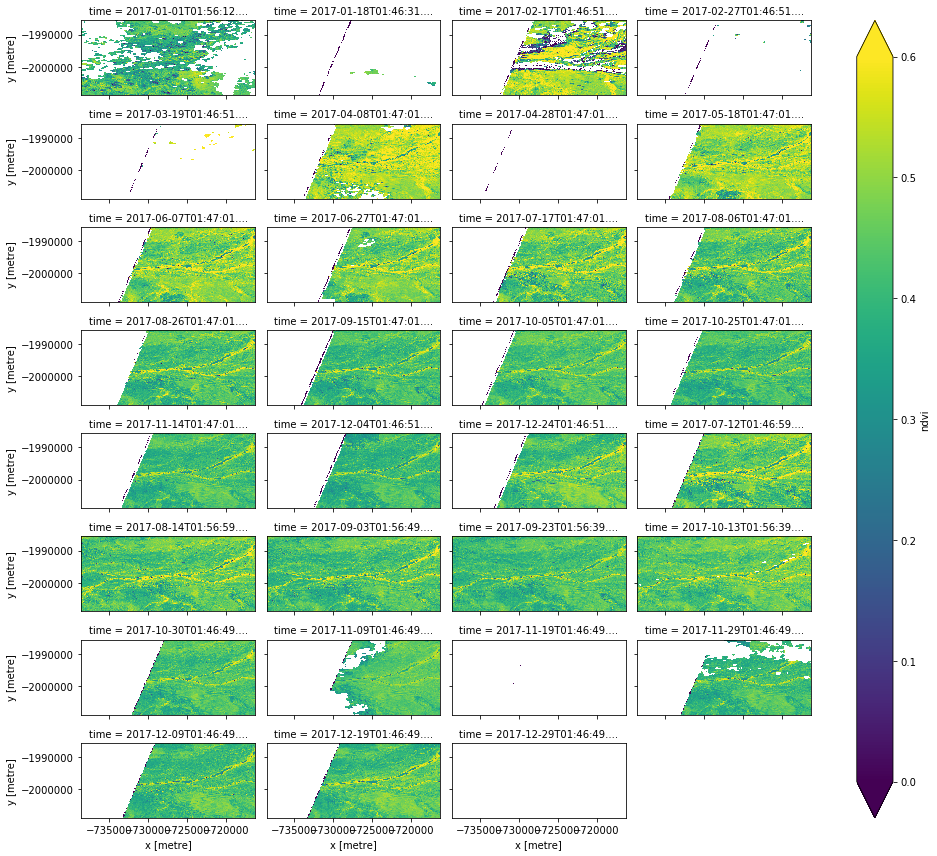

In [21]:
# View S2 NDVI time series
ntimes=len(s2_good_clean.time.values)
s2_good_clean.isel(time=slice(0,ntimes,2)).ndvi.plot(col='time', col_wrap=4, vmin=0.0, vmax=0.6, figsize=(14,12));

# Select area of interest to interactively to look at RVI, Entropy and NDVI time series

Populating the interactive namespace from numpy and matplotlib
Click on the pixel to view its time series below


<IPython.core.display.Javascript object>


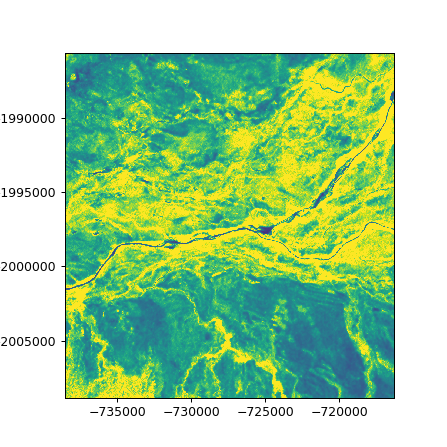

HTML(value='Click on the pixel to view its time series below')

In [13]:
%pylab notebook
warnings.filterwarnings('ignore')

def onclick(event):
    global pixelx, pixely
    x, y = int(event.xdata), int(event.ydata)
    image_coords = smoothed.affine * (x, y)
    pixelx = x 
    pixely = y 
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)
    print('data values:',x,y)

print('\033[1m' + 'Click on the pixel to view its time series below' + '\033[0m')

fig = plt.figure(figsize = (5,5))
plt.imshow(np.flip(smoothed.vv.mean(dim='time')), interpolation = 'nearest', clim=(0,0.1), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()]); 

w = widgets.HTML("Click on the pixel to view its time series below")

cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## Plot monthly time series based on selected pixel

In [14]:
# plot RVI, Entropy and NDVI through time based on the x,y point selected

import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
warnings.filterwarnings('ignore', module='datacube')

# expand selected x,y pixel to make a square area of interest
xp, yp=slice(pixelx+100,pixelx-100), slice(pixely-100,pixely+100)

@interact(myname=['monthly RVI','monthly Entropy'])

def plot(myname='monthly RVI'):
    global myplot, myimage, mytitle
    if myname == 'monthly RVI': 
        (smoothed.sel(x=xp,y=yp).RVI.groupby('time.month').mean()).plot(color='r', figsize=(5,3));
        myplot = (smoothed.sel(x=xp,y=yp).RVI.groupby('time').mean())
        myimage = smoothed.RVI
        mytitle = 'RVI (all images)'
    if myname == 'monthly Entropy': 
        (dp.sel(x=xp,y=yp).entropy.groupby('time.month').mean()).plot(color='b', figsize=(5,3));
        myplot = (dp.sel(x=xp,y=yp).entropy.groupby('time').mean())
        myimage = dp.entropy
        mytitle = 'Entropy (all images)'
    #if myname == 'NDVI': 
    (s2_good_clean.sel(x=xp,y=yp).ndvi.groupby('time.month').mean()).plot(color='g', figsize=(5,3));
        #myplot = (s2_good_clean.sel(x=xp,y=yp).ndvi.groupby('time').mean())
        #myimage = s2_good_clean.ndvi

interactive(children=(Dropdown(description='myname', options=('monthly RVI', 'monthly Entropy'), value='monthl…

## View time series of selected timeseries (RVI or Entropy) based on all scenes
### Select a point to view scene

<IPython.core.display.Javascript object>


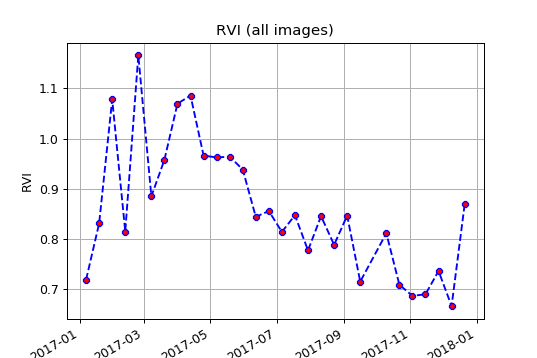

HTML(value='time_int: 736456.6443596375')

Text(0.5, 1.0, 'RVI (all images)')

In [18]:
# Click on a point in the time-series from RVI or Entropy (selected above) to display the image

#Use this plot to visualise a time series and select the image that corresponds with a point in the time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    w.value = 'time_int: {}'.format(time_int)

fig = plt.figure(figsize=(6,4))

fig.canvas.mpl_connect('button_press_event', callback)
plt.show()
display(w)
myplot.plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='r');
plt.grid()
plt.title(mytitle)

<IPython.core.display.Javascript object>


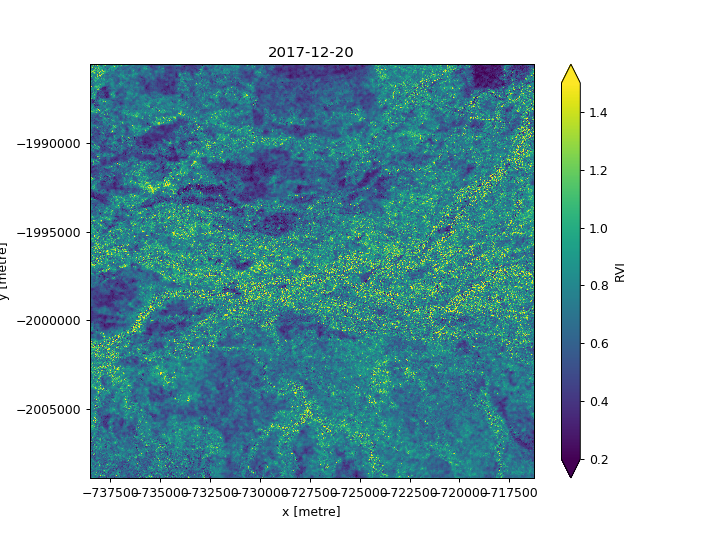

Text(0.5, 1.0, '2017-12-20')

In [20]:
# Plot image from selected time slice

time_slice = matplotlib.dates.num2date(time_int).date()
myimage.sel(time=time_slice, method='nearest').plot(vmin=0.2, vmax=1.5, figsize=(8,6));
plt.title(time_slice)

# Show Annual Statistics
## Annual difference in RVI, Entropy and NDVI

<IPython.core.display.Javascript object>


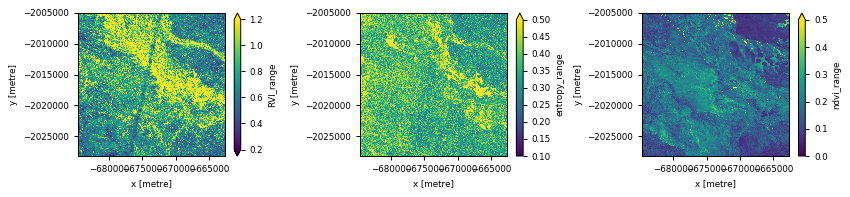

In [40]:
# Calculate annual range (max minus min) for radar backscatter RVI, dul-pol decomposition Entropy, and NDVI
from matplotlib import pyplot as plt
pylab.rcParams['font.size']=7

smoothed['RVI_range'] = smoothed.RVI.max(dim='time') - smoothed.RVI.min(dim='time')
dp['entropy_range'] = dp.entropy.max(dim='time') - dp.entropy.min(dim='time')
s2_good_clean['ndvi_range'] = s2_good_clean.ndvi.max(dim='time') - s2_good_clean.ndvi.min(dim='time')

fix, axes = plt.subplots(ncols=3, figsize=(9.5,2.2))

smoothed.RVI_range.plot(vmin=0.2,vmax=1.2, ax=axes[0]);
dp.entropy_range.plot(vmin=0.1,vmax=0.5, ax=axes[1]);
s2_good_clean.ndvi_range.plot(vmin=0.0,vmax=0.5, ax=axes[2]);
plt.tight_layout()
plt.draw()

## Annual RVI, Entropy and NDVI mean, min, max and std

<IPython.core.display.Javascript object>


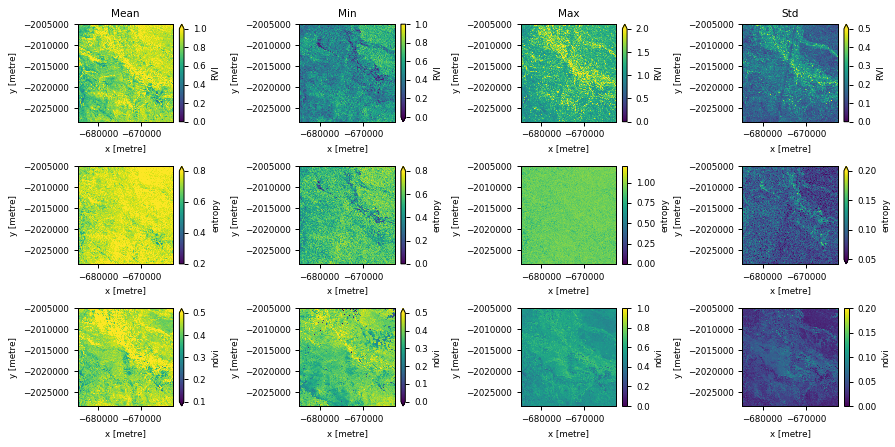

In [41]:
# Show RVI, Entropy and NDVI mean, min, max and stand deviation for current year

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(10,5))

smoothed.RVI.mean(dim='time').plot(vmin=0.0,vmax=1.0, ax=axes[0,0]);
smoothed.RVI.min(dim='time').plot(vmin=0.0,vmax=1.0, ax=axes[0,1]);
smoothed.RVI.max(dim='time').plot(vmin=0.0,vmax=2.0, ax=axes[0,2]);
smoothed.RVI.std(dim='time').plot(vmin=0.0,vmax=0.5, ax=axes[0,3]);
dp.entropy.mean(dim='time').plot(vmin=0.2,vmax=0.8, ax=axes[1,0]);
dp.entropy.min(dim='time').plot(vmin=0.0,vmax=0.8, ax=axes[1,1]);
dp.entropy.max(dim='time').plot(vmin=0.0,vmax=1.2, ax=axes[1,2]);
dp.entropy.std(dim='time').plot(vmin=0.05,vmax=0.2, ax=axes[1,3]);
s2_good_clean.ndvi.mean(dim='time').plot(vmin=0.1,vmax=0.5, ax=axes[2,0]);
s2_good_clean.ndvi.min(dim='time').plot(vmin=0.0,vmax=0.5, ax=axes[2,1]);
s2_good_clean.ndvi.max(dim='time').plot(vmin=0.0,vmax=1.0, ax=axes[2,2]);
s2_good_clean.ndvi.std(dim='time').plot(vmin=0.0,vmax=0.2, ax=axes[2,3]);

axes[0,0].set_title('Mean')
axes[0,1].set_title('Min')
axes[0,2].set_title('Max')
axes[0,3].set_title('Std')
plt.tight_layout()
plt.draw()

## Calculate and view monthly mean RVI images

<IPython.core.display.Javascript object>


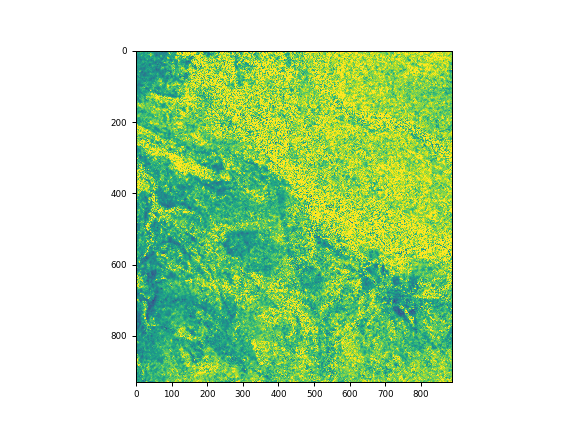

interactive(children=(Dropdown(description='month', options=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', …

In [42]:
# plot RVI, Entropy and NDVI through time based on the x,y point selected
#%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib import pyplot as plt

import pandas as pd
time = pd.to_datetime(['2017-01-01','2017-02-01','2017-03-01','2017-04-01','2017-05-01','2017-06-01',
                             '2017-07-01','2017-08-01','2017-09-01','2017-10-01','2017-11-01','2017-12-01'])

monthly_mean_RVI=xr.Dataset({'Jan':(smoothed.RVI.sel(time=slice('2017-01-01', '2017-01-31')).mean(dim='time')), 'time': time})
monthly_mean_RVI['Feb']=smoothed.RVI.sel(time=slice('2017-02-01', '2017-02-28')).mean(dim='time')
monthly_mean_RVI['Mar']=smoothed.RVI.sel(time=slice('2017-03-01', '2017-03-31')).mean(dim='time')
monthly_mean_RVI['Apr']=smoothed.RVI.sel(time=slice('2017-04-01', '2017-04-30')).mean(dim='time')
monthly_mean_RVI['May']=smoothed.RVI.sel(time=slice('2017-05-01', '2017-05-31')).mean(dim='time')
monthly_mean_RVI['Jun']=smoothed.RVI.sel(time=slice('2017-06-01', '2017-06-30')).mean(dim='time')
monthly_mean_RVI['Jul']=smoothed.RVI.sel(time=slice('2017-07-01', '2017-07-31')).mean(dim='time')
monthly_mean_RVI['Aug']=smoothed.RVI.sel(time=slice('2017-08-01', '2017-08-31')).mean(dim='time')
monthly_mean_RVI['Sep']=smoothed.RVI.sel(time=slice('2017-09-01', '2017-09-30')).mean(dim='time')
monthly_mean_RVI['Oct']=smoothed.RVI.sel(time=slice('2017-10-01', '2017-10-31')).mean(dim='time')
monthly_mean_RVI['Nov']=smoothed.RVI.sel(time=slice('2017-11-01', '2017-11-30')).mean(dim='time')
monthly_mean_RVI['Dec']=smoothed.RVI.sel(time=slice('2017-12-01', '2017-12-31')).mean(dim='time')

#monthly_mean_RVI = monthly_mean_RVI.assign_attrs(bs_attrs)

fig = plt.figure()

@interact(month=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

def plot(month='Jan'):
    if month == 'Jan': plt.imshow(np.flip(monthly_mean_RVI.Jan), clim=(0,1.0))
    if month == 'Feb': plt.imshow(np.flip(monthly_mean_RVI.Feb), clim=(0,1.0))
    if month == 'Mar': plt.imshow(np.flip(monthly_mean_RVI.Mar), clim=(0,1.0))
    if month == 'Apr': plt.imshow(np.flip(monthly_mean_RVI.Apr), clim=(0,1.0))
    if month == 'May': plt.imshow(np.flip(monthly_mean_RVI.May), clim=(0,1.0))
    if month == 'Jun': plt.imshow(np.flip(monthly_mean_RVI.Jun), clim=(0,1.0))
    if month == 'Jul': plt.imshow(np.flip(monthly_mean_RVI.Jul), clim=(0,1.0))
    if month == 'Aug': plt.imshow(np.flip(monthly_mean_RVI.Aug), clim=(0,1.0))
    if month == 'Sep': plt.imshow(np.flip(monthly_mean_RVI.Sep), clim=(0,1.0))
    if month == 'Oct': plt.imshow(np.flip(monthly_mean_RVI.Oct), clim=(0,1.0))
    if month == 'Nov': plt.imshow(np.flip(monthly_mean_RVI.Nov), clim=(0,1.0))
    if month == 'Dec': plt.imshow(np.flip(monthly_mean_RVI.Dec), clim=(0,1.0))


## Calculate and view monthly mean Entropy images

<IPython.core.display.Javascript object>


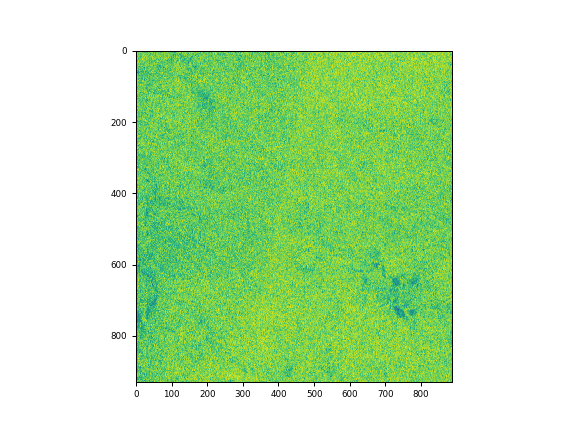

interactive(children=(Dropdown(description='month', options=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', …

In [43]:
# Display a monthly mean
# plot RVI, Entropy and NDVI through time based on the x,y point selected
#%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib import pyplot as plt

import pandas as pd
time = pd.to_datetime(['2017-01-01','2017-02-01','2017-03-01','2017-04-01','2017-05-01','2017-06-01',
                             '2017-07-01','2017-08-01','2017-09-01','2017-10-01','2017-11-01','2017-12-01'])

monthly_mean_entropy=xr.Dataset({'Jan':(dp.entropy.sel(time=slice('2017-01-01', '2017-01-31')).mean(dim='time')), 'time': time})
monthly_mean_entropy['Feb']=dp.entropy.sel(time=slice('2017-02-01', '2017-02-28')).mean(dim='time')
monthly_mean_entropy['Mar']=dp.entropy.sel(time=slice('2017-03-01', '2017-03-31')).mean(dim='time')
monthly_mean_entropy['Apr']=dp.entropy.sel(time=slice('2017-04-01', '2017-04-30')).mean(dim='time')
monthly_mean_entropy['May']=dp.entropy.sel(time=slice('2017-05-01', '2017-05-31')).mean(dim='time')
monthly_mean_entropy['Jun']=dp.entropy.sel(time=slice('2017-06-01', '2017-06-30')).mean(dim='time')
monthly_mean_entropy['Jul']=dp.entropy.sel(time=slice('2017-07-01', '2017-07-31')).mean(dim='time')
monthly_mean_entropy['Aug']=dp.entropy.sel(time=slice('2017-08-01', '2017-08-31')).mean(dim='time')
monthly_mean_entropy['Sep']=dp.entropy.sel(time=slice('2017-09-01', '2017-09-30')).mean(dim='time')
monthly_mean_entropy['Oct']=dp.entropy.sel(time=slice('2017-10-01', '2017-10-31')).mean(dim='time')
monthly_mean_entropy['Nov']=dp.entropy.sel(time=slice('2017-11-01', '2017-11-30')).mean(dim='time')
monthly_mean_entropy['Dec']=dp.entropy.sel(time=slice('2017-12-01', '2017-12-31')).mean(dim='time')

fig = plt.figure()

@interact(month=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

def plot(month='Jan'):
    if month == 'Jan': plt.imshow(np.flip(monthly_mean_entropy.Jan), clim=(0,1.0))
    if month == 'Feb': plt.imshow(np.flip(monthly_mean_entropy.Feb), clim=(0,1.0))
    if month == 'Mar': plt.imshow(np.flip(monthly_mean_entropy.Mar), clim=(0,1.0))
    if month == 'Apr': plt.imshow(np.flip(monthly_mean_entropy.Apr), clim=(0,1.0))
    if month == 'May': plt.imshow(np.flip(monthly_mean_entropy.May), clim=(0,1.0))
    if month == 'Jun': plt.imshow(np.flip(monthly_mean_entropy.Jun), clim=(0,1.0))
    if month == 'Jul': plt.imshow(np.flip(monthly_mean_entropy.Jul), clim=(0,1.0))
    if month == 'Aug': plt.imshow(np.flip(monthly_mean_entropy.Aug), clim=(0,1.0))
    if month == 'Sep': plt.imshow(np.flip(monthly_mean_entropy.Sep), clim=(0,1.0))
    if month == 'Oct': plt.imshow(np.flip(monthly_mean_entropy.Oct), clim=(0,1.0))
    if month == 'Nov': plt.imshow(np.flip(monthly_mean_entropy.Nov), clim=(0,1.0))
    if month == 'Dec': plt.imshow(np.flip(monthly_mean_entropy.Dec), clim=(0,1.0))

# Write output scenes to GeoTIFFs
## Output annual range and monthly mean RVI and Entropy images to GeoTIFF format

In [44]:
@interact(myoutputdir=['/g/data/qd04/Cate/TempProcessing/','/g/data/qd04/Cate/'])

def plot(myoutputdir='/g/data/qd04/Cate/TempProcessing/'):
    global mydir
    if myoutputdir == '/g/data/qd04/Cate/TempProcessing/': mydir = '/g/data/qd04/Cate/TempProcessing/'
    if myoutputdir == '/g/data/qd04/Cate/':mydir = '/g/data/qd04/Cate/'

interactive(children=(Dropdown(description='myoutputdir', options=('/g/data/qd04/Cate/TempProcessing/', '/g/da…

In [45]:
@interact(myoutputfiles=['output files','stop'])

def plot(myoutputfiles='stop'):
    if myoutputfiles == 'output files': 
        print('Writing GeoTIFF files')
    
        # write output images (in Albers) to GeoTIFF

        import ogr, gdal, osr

        #mydir = '/g/data/qd04/Cate/TempProcessing/'

        # define coordinates for Albers equal area (3577)
        xcoords = smoothed.isel(time=1).vv.indexes['x']
        ycoords = smoothed.isel(time=1).vv.indexes['y']
        yt,xt = smoothed.isel(time=1).vv.shape
        MaxValX = xcoords.shape
        MaxValY = ycoords.shape

        # set geotransform and output projection
        xres = 25 
        yres = 25 
        geotransform = (xcoords[MaxValX[0]-1]-(xres*0.5), xres, 0, ycoords[MaxValY[0]-1]+(yres*0.5), 0, -yres) # offset by half the pixel size since it needs to be top-left pixel coord
        srs = osr.SpatialReference() 
        srs.ImportFromEPSG(3577)

        # loop through monthly images
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

        # Edit output filenames (filename_RVI and filename_entropy) and directory as required
        for month in months:

            filename_RVI = 'S1_RVI_3577_'+ month +'_'+ Year +'.tif' 
            S1_ds = gdal.GetDriverByName('GTiff').Create(mydir+filename_RVI, 
                                                           xt, yt, 1, gdal.GDT_Float32)
            S1_ds.SetGeoTransform(geotransform) # specify coordinates
            S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
            S1_ds.GetRasterBand(1).WriteArray(np.flip(monthly_mean_RVI[month]).data) # write band to raster
            S1_ds.FlushCache()  # write to file
            S1_ds = None # save and close

            filename_entropy = 'S1_Entropy_3577_'+ month + '_'+ Year + '.tif' 
            S1_ds = gdal.GetDriverByName('GTiff').Create(mydir+filename_entropy, 
                                                           xt, yt, 1, gdal.GDT_Float32)
            S1_ds.SetGeoTransform(geotransform) # specify coordinates
            S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
            S1_ds.GetRasterBand(1).WriteArray(np.flip(monthly_mean_entropy[month]).data) # write band to raster
            S1_ds.FlushCache()  # write to file
            S1_ds = None # save and close

        # Output annual RVI and Entropy range images
        filename_RVI = 'S1_RVI_3577_Annual_Range_' + Year +'.tif' 
        S1_ds = gdal.GetDriverByName('GTiff').Create(mydir+filename_RVI, 
                                                           xt, yt, 1, gdal.GDT_Float32)
        S1_ds.SetGeoTransform(geotransform) # specify coordinates
        S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
        S1_ds.GetRasterBand(1).WriteArray(np.flip(smoothed.RVI_range).data) # write band to raster
        S1_ds.FlushCache()  # write to file
        S1_ds = None # save and close

        # Output annual RVI and Entropy range images
        filename_entropy = 'S1_Entropy_3577_Annual_Range_' + Year + '.tif' 
        S1_ds = gdal.GetDriverByName('GTiff').Create(mydir+filename_entropy, 
                                                           xt, yt, 1, gdal.GDT_Float32)
        S1_ds.SetGeoTransform(geotransform) # specify coordinates
        S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
        S1_ds.GetRasterBand(1).WriteArray(np.flip(dp.entropy_range).data) # write band to raster
        S1_ds.FlushCache()  # write to file
        S1_ds = None # save and close

    if myoutputfiles == 'stop': print('Finished without writing GeoTIFF files')

interactive(children=(Dropdown(description='myoutputfiles', index=1, options=('output files', 'stop'), value='…